In [1]:
import os
import cv2
import sys
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

Using TensorFlow backend.


In [2]:
PROGRAM_PATH = os.path.abspath("..")
if PROGRAM_PATH not in sys.path:
    sys.path.append(PROGRAM_PATH)

In [3]:
from Helpers.GeneralHelpers import *
from Helpers.RHDHelpers import *
from DataHandling.PreProcessing import *
from Model.PoolingAndFire import create_loss_function

In [4]:
MODEL_FILE = os.path.expanduser("~/results/SVPGestureRec/all_points_test.h5py")
#MODEL_FILE = os.path.expanduser("~/results/SqueezeDet/all_points_complete_run_09.h5py")
#MODEL_FILE = os.path.expanduser("~/results/SVPGestureRec/all_points_overfit_32.h5py")
RHD_ANNOTATIONS_FILE = os.path.expanduser("~/datasets/RHD/RHD_published_v2/training/anno_training.pickle")
VALIDATION_DIR = os.path.expanduser("~/datasets/RHD/processed/validation")
TRAIN_DIR = os.path.expanduser("~/datasets/RHD/processed/train")
VALIDATION_ANNOTATIONS = os.path.expanduser("~/datasets/RHD/processed/validation/annotations/")
TRAIN_ANNOTATIONS = os.path.expanduser("~/datasets/RHD/processed/train/annotations/")

In [5]:
create_rhd_annotations(RHD_ANNOTATIONS_FILE,
                       VALIDATION_ANNOTATIONS,
                       VALIDATION_DIR,
                       fingers='ALL',
                       hands_to_annotate='BOTH',
                       annotate_non_visible=False,
                       force_new_files=True)

100%|██████████| 413/413 [00:00<00:00, 4732.61it/s]

Creating annotations in directory: /home/clh/datasets/RHD/processed/validation
Using annotation file: /home/clh/datasets/RHD/RHD_published_v2/training/anno_training.pickle
And outputting to: /home/clh/datasets/RHD/processed/validation/annotations/


In [6]:
BATCHSIZE = 16
EPSILON = 1e-16

LABEL_WEIGHT = 1.0
OFFSET_LOSS_WEIGHT = 1.0
OFFSET_SCALE = int(320 / 20) / 2

NUM_CLASSES = 42
NUM_HANDS = 2

l = create_loss_function(20,
                         20,
                         LABEL_WEIGHT,
                         OFFSET_LOSS_WEIGHT,
                         NUM_CLASSES,
                         EPSILON,
                         BATCHSIZE)

In [7]:
model = load_model(MODEL_FILE, custom_objects={'loss_function': l})

In [8]:
#model.summary()

In [9]:
samples_dir = VALIDATION_DIR
annotations_dir = VALIDATION_ANNOTATIONS
NUM_SAMPLES_TO_CHECK = BATCHSIZE

In [10]:
#samples_to_check = []
#for fi in os.listdir(samples_dir):
#    if fi.endswith('png'):
#        samples_to_check.append(int(fi.split('.')[0]))
#        if len(samples_to_check) >= NUM_SAMPLES_TO_CHECK:
#            break

#print(samples_to_check)

In [11]:
samples = np.array(sorted(get_all_samples(samples_dir, sample_type='png')))
ind = np.random.randint(0, len(samples), size=NUM_SAMPLES_TO_CHECK)
ind = range(10)
samples_to_check = samples[ind]
print(samples_to_check)

[40846 40847 40848 40849 40850 40851 40852 40853 40854 40855]


In [12]:
labels, images = load_data_with_anchors(samples_to_check,
                                        samples_dir,
                                        annotations_dir,
                                        320, 320,
                                        20, 20,
                                        OFFSET_SCALE,
                                        'png',
                                        num_classes=NUM_CLASSES,
                                        greyscale=True)

images_show = np.zeros((len(images), 320, 320, 3), dtype=np.uint8)
#for c, im in enumerate(images):
#    #images_show[c] = cv2.cvtColor((im * 255.0).astype(np.uint8), cv2.COLOR_BGR2RGB)
#    images_show[c][:, :, 0] = im.reshape(320, 320) * 255.0
#    images_show[c][:, :, 1] = im.reshape(320, 320) * 255.0
#    images_show[c][:, :, 2] = im.reshape(320, 320) * 255.0

for c, s in enumerate(samples_to_check):
    images_show[c] = load_image(samples_dir, s)

print(np.max(images[0]))

5.297399044036865


In [13]:
for l in labels:
    print(l.shape)
    for i in range(NUM_CLASSES):
        offset_xs = l[:, :, NUM_CLASSES+i*2]
        offset_ys = l[:, :, NUM_CLASSES+1+i*2]
        
        print(f"Offset max x: {np.max(offset_xs)}")
        print(f"Offset max y: {np.max(offset_ys)}")
        print("")

(20, 20, 126)
Offset max x: 0.0
Offset max y: 0.0

Offset max x: 0.9249992370605469
Offset max y: 0.0

Offset max x: 0.0
Offset max y: 0.08749961853027344

Offset max x: 0.0
Offset max y: 0.0

Offset max x: 0.0
Offset max y: 0.8374996185302734

Offset max x: 0.6499996185302734
Offset max y: 0.0

Offset max x: 0.5125007629394531
Offset max y: 0.6999998092651367

Offset max x: 0.0
Offset max y: 0.0

Offset max x: 0.0
Offset max y: 0.35000038146972656

Offset max x: 0.0
Offset max y: 0.0

Offset max x: 0.0
Offset max y: 0.28750038146972656

Offset max x: 0.0
Offset max y: 0.0

Offset max x: 0.0
Offset max y: 0.0

Offset max x: 0.0
Offset max y: 0.17499923706054688

Offset max x: 0.0
Offset max y: 0.0

Offset max x: 0.0
Offset max y: 0.41250038146972656

Offset max x: 0.0
Offset max y: 0.0

Offset max x: 0.0
Offset max y: 0.16250038146972656

Offset max x: 0.0
Offset max y: 0.21249961853027344

Offset max x: 0.5749998092651367
Offset max y: 0.125

Offset max x: 0.0
Offset max y: 0.39999961

In [14]:
right_hand = []
left_hand = []

with open(RHD_ANNOTATIONS_FILE, 'rb') as f:
    annotations = pickle.load(f)
    
for s in samples_to_check:
    right_hand.append(get_right_hand(s, annotations))
    left_hand.append(get_left_hand(s, annotations))

In [15]:
res = np.zeros(labels.shape)
process_times = []
for c, im in enumerate(images):
    before = time.time()
    #res.append(model.predict(im.reshape(1, 320, 320, 1)))
    res[c] = model.predict(im.reshape(1, 320, 320, 1))
    process_times.append(time.time() - before)
    
process_times = np.array(process_times)
print(f"Average processing time: {np.mean(process_times)}")
print(f"Max processing time: {np.max(process_times)}")
print(f"Min processing time: {np.min(process_times)}")
print(f"Average processing time excepting first: {np.mean(process_times[1:])}")

Average processing time: 0.21396369934082032
Max processing time: 1.9115374088287354
Min processing time: 0.024688243865966797
Average processing time excepting first: 0.02534439828660753


In [16]:
for c, l in enumerate(labels):
    for i in range(NUM_CLASSES):
        finger_index = i
        if finger_index >= 21:
            finger_index -= 21
        
        single_label = np.zeros((20, 20, 3))
        single_label[:, :, 0] = labels[c, :, :, i]
        single_label[:, :, 1] = labels[c, :, :, NUM_CLASSES+i*2]
        single_label[:, :, 2] = labels[c, :, :, NUM_CLASSES+1+i*2]
        
        anchors = get_anchors(320, 320, 20, 20)

        label_points = get_all_points_from_prediction(single_label,
                                                      anchors,
                                                      threshold=1.0,
                                                      offset_weight=OFFSET_SCALE)
        
        x_points = np.zeros(len(label_points))
        y_points = np.zeros(len(label_points))
        for counter, p in enumerate(label_points):
            #x = p[0] + p[2]
            #y = p[1] + p[3]
            x_points[counter] = p[0] + p[2]
            y_points[counter] = p[1] + p[2]
        
        if len(label_points) > 0:
            x = np.mean(x_points)
            y = np.mean(y_points)

            print(f"{FINGER_MAP_INV[finger_index]}: ({x:.2f}, {y:.2f}), anchor point: ({p[0]:.2f}, {p[1]:.2f}), offset: ({p[2]:.2f}, {p[3]:.2f}), number: {len(label_points)}")

            cv2.circle(images_show[c], (int(x), int(y)), 1, (0, 255, 0), thickness=2)

Thumb1: (144.40, 113.40), anchor point: (137.00, 106.00), offset: (7.40, -3.00), number: 1
Thumb2: (150.30, 104.30), anchor point: (152.00, 106.00), offset: (-1.70, 0.70), number: 1
Thumb3: (147.80, 116.80), anchor point: (152.00, 121.00), offset: (-4.20, -4.40), number: 1
Thumb4: (137.00, 121.00), anchor point: (137.00, 121.00), offset: (0.00, 6.70), number: 1
Index1: (142.20, 126.20), anchor point: (137.00, 121.00), offset: (5.20, -1.80), number: 1
Index2: (141.10, 110.10), anchor point: (137.00, 106.00), offset: (4.10, 5.60), number: 1
Index3: (130.00, 99.00), anchor point: (137.00, 106.00), offset: (-7.00, -1.50), number: 1
Index4: (120.90, 105.90), anchor point: (121.00, 106.00), offset: (-0.10, 2.80), number: 1
Middle1: (136.00, 136.00), anchor point: (137.00, 137.00), offset: (-1.00, -7.00), number: 1
Middle2: (134.30, 118.30), anchor point: (137.00, 121.00), offset: (-2.70, 2.30), number: 1
Middle4: (114.60, 114.60), anchor point: (121.00, 121.00), offset: (-6.40, -3.00), numbe

Wrist: (154.00, 62.00), anchor point: (152.00, 60.00), offset: (2.00, -1.74), number: 1
Thumb1: (154.30, 139.30), anchor point: (152.00, 137.00), offset: (2.30, 0.10), number: 1
Thumb2: (163.80, 117.80), anchor point: (167.00, 121.00), offset: (-3.20, -0.80), number: 1
Thumb3: (168.70, 92.70), anchor point: (167.00, 91.00), offset: (1.70, 3.50), number: 1
Thumb4: (162.60, 71.60), anchor point: (167.00, 76.00), offset: (-4.40, -0.70), number: 1
Index1: (138.50, 176.00), anchor point: (137.00, 182.00), offset: (1.50, -7.50), number: 2
Index2: (135.00, 150.00), anchor point: (137.00, 152.00), offset: (-2.00, 4.40), number: 1
Index3: (133.20, 133.20), anchor point: (137.00, 137.00), offset: (-3.80, -0.60), number: 1
Index4: (140.20, 109.20), anchor point: (137.00, 106.00), offset: (3.20, 7.00), number: 1
Middle2: (134.60, 149.60), anchor point: (137.00, 152.00), offset: (-2.40, 6.60), number: 1
Middle4: (133.30, 117.30), anchor point: (137.00, 121.00), offset: (-3.70, -4.50), number: 1
Rin

In [17]:
arr = np.array([0, 1, 2, 3])
np.clip(arr, 0, 1)

array([0, 1, 1, 1])

In [18]:
THRESHOLD = 0.8

for c, r in enumerate(res):
    #print(r.shape)
    #pred = r.reshape(20, 20, 3)
    
    for i in range(NUM_CLASSES):
        
        finger_index = i
        if finger_index >= 21:
            finger_index -= 21
        
        pred = np.zeros((20, 20, 3))
        
        pred[:, :, 0] = res[c, :, :, i]
        pred[:, :, 1] = res[c, :, :, NUM_CLASSES+i*2]
        pred[:, :, 2] = res[c, :, :, NUM_CLASSES+1+i*2]
        
        #print(np.max(pred[:, :, 0]))
        
        anchors = get_anchors(320, 320, 20, 20)
        max_conf = np.max(pred[:,:,0])
        max_val = 0.8
        pred_point = get_all_points_from_prediction(pred,
                                                    anchors,
                                                    threshold=THRESHOLD,
                                                    offset_weight=OFFSET_SCALE,
                                                    is_label=False)
        
        # Find a way to handle outliers
        if len(pred_point) > 0:
            x_points = np.zeros(len(pred_point))
            y_points = np.zeros(len(pred_point))
            for counter, p in enumerate(pred_point):
                #x = p[0] + p[2]
                #y = p[1] + p[3]
                x_points[counter] = p[0] + p[2]
                y_points[counter] = p[1] + p[2]

            x = np.mean(x_points)
            y = np.mean(y_points)

            print(f"{FINGER_MAP_INV[finger_index]}  Predicted point: ({x}, {y}), max confidence: {max_conf}, num: {len(pred_point)}")

            cv2.circle(images_show[c], (int(x), int(y)), 1, (255, 0, 0), thickness=1)

Wrist  Predicted point: (138.38009452819824, 145.88009452819824), max confidence: 0.9241983294487, num: 2
Thumb1  Predicted point: (141.96875802675882, 100.96875802675883), max confidence: 0.9764585494995117, num: 3
Thumb2  Predicted point: (141.60897862911224, 103.10897862911224), max confidence: 0.9951539039611816, num: 2
Thumb3  Predicted point: (143.4200029373169, 127.4200029373169), max confidence: 0.9939186573028564, num: 1
Thumb4  Predicted point: (139.7416286468506, 139.7416286468506), max confidence: 0.9879963994026184, num: 1
Index1  Predicted point: (143.5506916642189, 112.5506916642189), max confidence: 0.9950689077377319, num: 4
Index2  Predicted point: (133.301691532135, 102.30169153213501), max confidence: 0.9964847564697266, num: 1
Index3  Predicted point: (128.2796677350998, 105.27966773509979), max confidence: 0.9800639152526855, num: 2
Index4  Predicted point: (126.54452669620514, 103.54452669620514), max confidence: 0.9427403211593628, num: 2
Middle1  Predicted poin

Index1  Predicted point: (96.02028465270996, 147.02028465270996), max confidence: 0.9950716495513916, num: 3
Index2  Predicted point: (105.31947612762451, 128.3194761276245), max confidence: 0.9836246967315674, num: 2
Index3  Predicted point: (115.72081311543782, 115.72081311543782), max confidence: 0.990035891532898, num: 3
Index4  Predicted point: (135.51891088485718, 104.51891088485718), max confidence: 0.8793565630912781, num: 1
Middle1  Predicted point: (114.72830486297607, 149.22830486297607), max confidence: 0.9851712584495544, num: 4
Middle2  Predicted point: (124.11556259791057, 139.78222926457724), max confidence: 0.9483497738838196, num: 3
Middle3  Predicted point: (120.295490026474, 112.795490026474), max confidence: 0.9953527450561523, num: 2
Middle4  Predicted point: (141.107647895813, 117.60764789581299), max confidence: 0.8491378426551819, num: 2
Ring1  Predicted point: (145.52167129516602, 149.52167129516602), max confidence: 0.8932964205741882, num: 4
Ring2  Predicted

In [19]:
def confidence_score(label, prediction, num_classes):
    """
    How often does the model tag the correct anchor.
    """
    error = 0
    for i in range(num_classes):
        l = label[:, :, i]
        p = prediction[:, :, i]
        
        label_x, label_y = np.where(l==1.0)
        try:
            label_point = np.array([label_x[0], label_y[0]])
            print(f"label_point: {label_point}")
        except:
            #print("Error")
            continue

        prediction_x, prediction_y = np.where(p==np.max(p))
        prediction_point = np.array([prediction_x[0], prediction_y[0]])
        
        print(f"prediction_point: {prediction_point}")
        
        label_error = np.linalg.norm(label_point - prediction_point)
        error += label_error
        print(label_error)
        
        print("")
    
    return error

#print(res.shape)
confidence_score(labels[0], res[0], 42)

label_point: [8 6]
prediction_point: [8 6]
0.0

label_point: [9 6]
prediction_point: [8 6]
1.0

label_point: [9 7]
prediction_point: [8 7]
1.0

label_point: [8 7]
prediction_point: [8 8]
1.0

label_point: [8 7]
prediction_point: [8 7]
0.0

label_point: [8 6]
prediction_point: [8 6]
0.0

label_point: [8 6]
prediction_point: [7 6]
1.0

label_point: [7 6]
prediction_point: [7 6]
0.0

label_point: [8 8]
prediction_point: [8 7]
1.0

label_point: [8 7]
prediction_point: [8 7]
0.0

label_point: [7 7]
prediction_point: [7 7]
0.0

label_point: [8 8]
prediction_point: [8 8]
0.0

label_point: [7 7]
prediction_point: [7 7]
0.0

label_point: [7 8]
prediction_point: [8 8]
1.0

label_point: [7 8]
prediction_point: [7 8]
0.0

label_point: [6 8]
prediction_point: [7 8]
1.0

label_point: [7 8]
prediction_point: [7 8]
0.0



7.0

In [20]:
def accuracy():
    pass

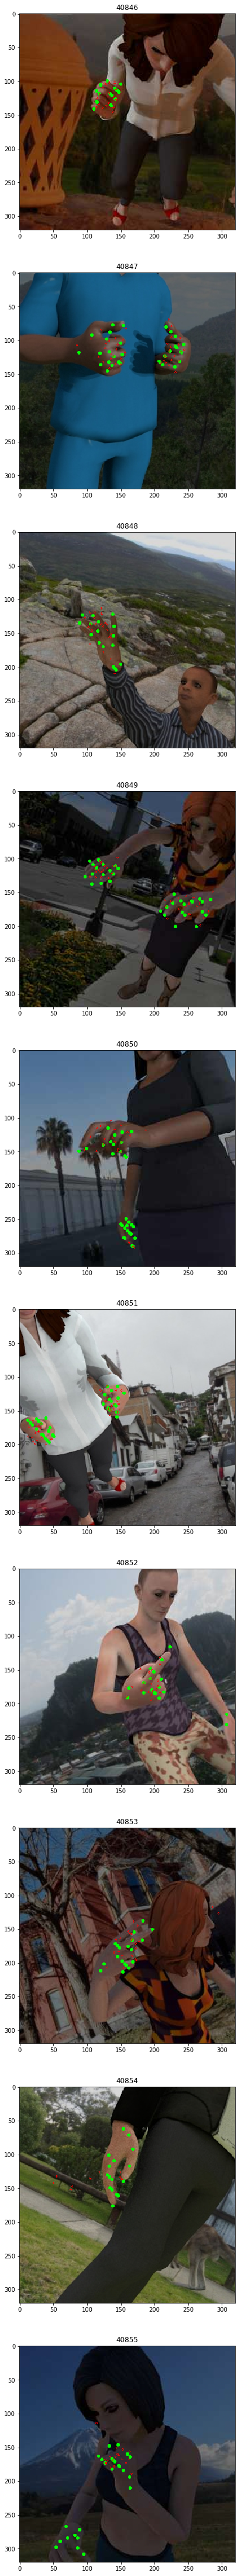

In [21]:
f, subs = plt.subplots(len(images_show), 1, figsize=(15, 8*len(samples_to_check)))
for c, im in enumerate(images_show):
    subs[c].imshow(im)
    #subs[c].set_title(f"Confidence: {np.max(res[c][:,:,:,0])}")
    subs[c].set_title(f"{samples_to_check[c]}")

#f = plt.figure(figsize=(20, 20))
#plt.imshow(images_show[0], cmap='gray')